In [2]:
import sys, os

sys.path.append(os.path.abspath('..'))

In [3]:
from torch import empty, Tensor

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
from utils import generate, load_dataset, standardized
import pandas as pd

## Testing data generation

In [5]:
train_input, train_target, test_input, test_target, mu, sigma= load_dataset(1000, standardize=True)

<AxesSubplot:xlabel='x', ylabel='y'>

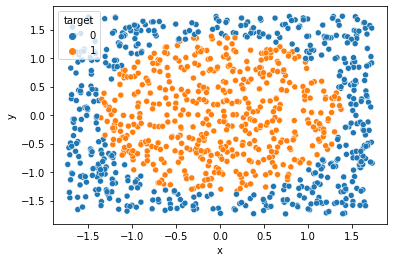

In [6]:
df = pd.DataFrame(train_input.tolist())

df['target'] = train_target.tolist()
df.columns = ['x', 'y', 'target']

sns.scatterplot(data=df, x='x', y='y', hue='target')

## Testing loss

In [7]:
from torch import tensor

In [8]:
from flame.nn.module import Module


class MSELoss(Module):
    def __init__(self):
        super().__init__()

    def forward(self, prediction, target):
        
        print(prediction)
        print(target)
        
        self.prediction = prediction.view(-1)
        self.target = target
        return (prediction - target).pow(2).mean()

    def backward(self):
        return 2 * (self.prediction - self.target) / (self.prediction.size(0))

In [9]:
prediction = tensor([[-0.4433],
        [-0.2356],
        [-0.2109],
        [-0.1666],
        [-0.3752],
        [-0.0956],
        [-0.3019],
        [-0.0784],
        [-0.2483],
        [-0.0612]])
target = tensor([0, 1, 1, 1, 0, 1, 0, 1, 1, 1])

In [10]:
criterion = MSELoss()

In [11]:
criterion(prediction, target)

tensor([[-0.4433],
        [-0.2356],
        [-0.2109],
        [-0.1666],
        [-0.3752],
        [-0.0956],
        [-0.3019],
        [-0.0784],
        [-0.2483],
        [-0.0612]])
tensor([0, 1, 1, 1, 0, 1, 0, 1, 1, 1])


tensor(1.0741)

In [12]:
criterion.backward()

tensor([-0.0887, -0.2471, -0.2422, -0.2333, -0.0750, -0.2191, -0.0604, -0.2157,
        -0.2497, -0.2122])

# Evaluate Metrics

In [13]:
import matplotlib as mpl

SMALL_SIZE = 10
MEDIUM_SIZE = 12
LARGE_SIZE = 16

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = SMALL_SIZE
mpl.rcParams['axes.titlesize'] = SMALL_SIZE
mpl.rcParams['axes.labelsize'] = MEDIUM_SIZE
mpl.rcParams['xtick.labelsize'] = SMALL_SIZE
mpl.rcParams['ytick.labelsize'] = SMALL_SIZE
mpl.rcParams['legend.fontsize'] = SMALL_SIZE
mpl.rcParams['figure.titlesize'] = LARGE_SIZE

mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.facecolor'] = '#F5F5F5'
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['figure.figsize'] = [6, 3.259]

In [14]:
#df = pd.read_json('../results/metrics.json')

#df['model'] = df['optimizer'] + ' ' + df['criterion'] 

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3.25), dpi=100)

g = sns.lineplot(data=df, x='epoch', y='loss', hue='model', ax=axes[0], legend='brief')
sns.lineplot(data=df, x='epoch', y='accuracy', hue='model', ax=axes[1], legend=False)

h,l = g.axes.get_legend_handles_labels()
g.axes.legend_.remove()
lgd = fig.legend(h,l, ncol=4, bbox_to_anchor=(0.9, 1.10))

plt.tight_layout()
fig.savefig('../figures/training.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=fig.dpi)
plt.show()

ValueError: Could not interpret value `epoch` for parameter `x`

# What does our model actually show?

In [16]:
import flame
from flame import nn

from train import train
from utils import load_dataset
from metrics import evaluate_accuracy

In [17]:
train_input, train_target, \
        test_input, test_target, mu, sigma = load_dataset(1000, standardize=True)

In [18]:
model = nn.Sequential([
    nn.Linear(2, 25), nn.ReLU(),
    nn.Linear(25, 25), nn.Dropout(p=0.3), nn.ReLU(),
    nn.Linear(25, 25), nn.ReLU(),
    nn.Linear(25, 1)])

model.init_weights()

model.train()

train(model, train_input, train_target, verbose=1)

Epoch 05 	Loss 13.719 	Acc. 86.000
Epoch 10 	Loss 10.428 	Acc. 89.200
Epoch 15 	Loss 8.983 	Acc. 89.800
Epoch 20 	Loss 7.931 	Acc. 94.500
Epoch 25 	Loss 7.246 	Acc. 95.100
Epoch 30 	Loss 6.527 	Acc. 96.500
Epoch 35 	Loss 6.124 	Acc. 97.700
Epoch 40 	Loss 5.628 	Acc. 98.700
Epoch 45 	Loss 4.960 	Acc. 98.200
Epoch 50 	Loss 4.748 	Acc. 98.700


In [19]:
evaluate_accuracy(model, test_input, test_target).item()

0.9869999885559082

In [20]:
prediction = model(test_input).flatten()

df = pd.DataFrame(test_input.mul_(sigma).add_(mu).tolist())

df['prediction'] = ((prediction > .2).float() + (prediction > .8).float()).tolist()
df['prediction_real'] = prediction.tolist()
df.columns = ['x', 'y', 'prediction', 'prediction_real']

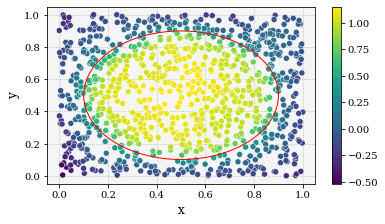

In [21]:
import math

ax = sns.scatterplot(data=df, x='x', y='y', hue='prediction_real', palette='viridis')

norm = plt.Normalize(df['prediction_real'].min(), df['prediction_real'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

circle = plt.Circle((0.5, 0.5), 1 / math.sqrt(2 * math.pi), color='r', fill=False)

ax.add_patch(circle)

plt.savefig('../figures/test-distribution.png')

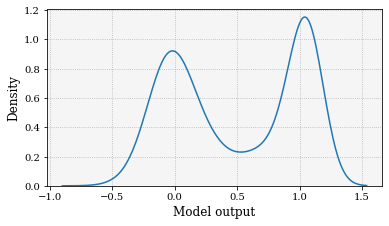

In [22]:
ax = sns.kdeplot(data=df, x='prediction_real', )

ax.set_xlabel('Model output')

plt.savefig('../figures/output-distribution.png')

In [23]:
prediction = model(test_input).flatten()

<AxesSubplot:>

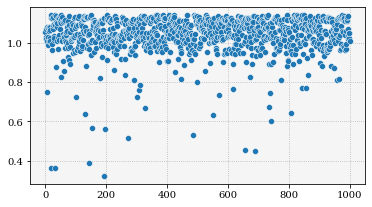

In [24]:
sns.scatterplot(x=list(range(prediction.size(0))), y=prediction.tolist())

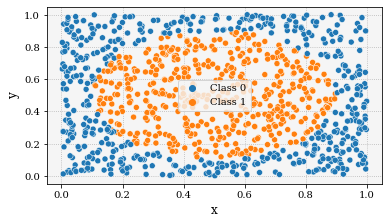

In [57]:

import pandas as pd
train_input, train_target, test_input, test_target= load_dataset(1000, standardize=False)
df = pd.DataFrame(train_input.tolist())

classe= list()
for i in range(train_target.shape[0]):
    if train_target[i]>0.5:
        classe.append("Class 1")
    elif train_target[i]<0.5:
        classe.append("Class 0")

df['Label'] = classe
df.columns = ['x', 'y', 'Label']
SMALL_SIZE = 10
MEDIUM_SIZE = 12
LARGE_SIZE = 16

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = SMALL_SIZE
mpl.rcParams['axes.titlesize'] = SMALL_SIZE
mpl.rcParams['axes.labelsize'] = MEDIUM_SIZE
mpl.rcParams['xtick.labelsize'] = SMALL_SIZE
mpl.rcParams['ytick.labelsize'] = SMALL_SIZE
mpl.rcParams['legend.fontsize'] = SMALL_SIZE
mpl.rcParams['figure.titlesize'] = LARGE_SIZE

mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.facecolor'] = '#F5F5F5'
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['figure.figsize'] = [6, 3.259]


sns_plot=sns.scatterplot(data=df, x='x', y='y', hue='Label')
sns_plot.legend(title="",loc='center')
fig = sns_plot.get_figure()
fig.savefig('data.png')

Epoch 05 	Loss 19.306 	Acc. 74.200
Epoch 10 	Loss 15.730 	Acc. 79.300
Epoch 15 	Loss 12.837 	Acc. 89.600
Epoch 20 	Loss 10.807 	Acc. 90.900
Epoch 25 	Loss 9.710 	Acc. 92.200
Epoch 30 	Loss 8.490 	Acc. 95.100
Epoch 35 	Loss 8.194 	Acc. 95.600
Epoch 40 	Loss 7.016 	Acc. 97.200
Epoch 45 	Loss 6.708 	Acc. 96.700
Epoch 50 	Loss 6.425 	Acc. 96.800


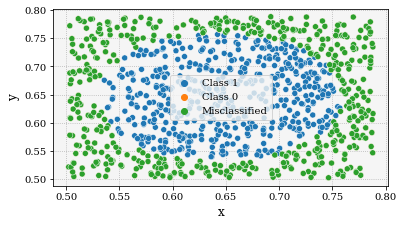

In [58]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import sys, os
sys.path.append(os.path.abspath('..'))
from torch import manual_seed

from flame import nn
from train import train
from metrics import evaluate_accuracy
from utils import load_dataset

model = nn.Sequential([
    nn.Linear(2, 25), nn.ReLU(),
    nn.Linear(25, 25), nn.Dropout(p=0.3), nn.ReLU(),
    nn.Linear(25, 25), nn.ReLU(),
    nn.Linear(25, 1)])

model.init_weights()

model.train()
train_input, train_target, test_input, test_target= load_dataset(1000, standardize=True)
train(model, train_input, train_target, verbose=1)

# MODELING #
#  OUTPUT  #



model.train(False)

test_input.mul_(sigma).add_(mu)


output = model(test_input).flatten()
prediction = ((output > .5) == test_target).float()-1
mistakes_idx=prediction.nonzero()
mistakes=test_input[mistakes_idx,:]

test_input=torch.cat((test_input, mistakes.view(-1,2)))
test_target=torch.cat((test_target,-1*torch.ones(mistakes.shape[0])))

classe= list()
for i in range(test_target.shape[0]):
    if test_target[i]<-0.5:
        classe.append("Misclassified")
    elif test_target[i]>0.5:
        classe.append("Class 1")
    elif test_target[i]<0.5 and test_target[i]>-0.5:
        classe.append("Class 0")


SMALL_SIZE = 10
MEDIUM_SIZE = 12
LARGE_SIZE = 16

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = SMALL_SIZE
mpl.rcParams['axes.titlesize'] = SMALL_SIZE
mpl.rcParams['axes.labelsize'] = MEDIUM_SIZE
mpl.rcParams['xtick.labelsize'] = SMALL_SIZE
mpl.rcParams['ytick.labelsize'] = SMALL_SIZE
mpl.rcParams['legend.fontsize'] = SMALL_SIZE
mpl.rcParams['figure.titlesize'] = LARGE_SIZE

mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.facecolor'] = '#F5F5F5'
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['figure.figsize'] = [6, 3.259]

df = pd.DataFrame(test_input.tolist())
df['Label'] = classe
df.columns = ['x', 'y', 'Label']

sns_plot=sns.scatterplot(data=df, x='x', y='y', hue='Label')
sns_plot.legend(title="")

fig = sns_plot.get_figure()

fig.savefig("test.png")